In [1]:
import os 
os.chdir("..")
os.chdir("..")
from src.cpwc.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch
from src.cpwc.tools.ptychography import Ptychography as Ptychography
from src.cpwc.tools.utils import *
torch.cuda.empty_cache()
from src.utils.cuda_pyth import empty_cuda, print_cuda_tensors
from src.utils.get_image import get_image
from src.utils.noise import add_gaussian_noise, add_poisson_noise
from src.utils.metrics import get_ring_average
from src.utils.manage_data import save_data,unwrap_2d,extract_data
# Set seeds 
torch.manual_seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
max_scale = 9
image,image_tensor_ = get_image("samples/potential.npy", max_scale,device)
max_probe_size = 128
cycle = [0, -1, -1, -1,  1, 1, 1]
tol = [1e-10] * 9
tol_in = [1e-15] * 9


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LR = 1e-2
max_shift = 64
I_in = 25*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 30, 10,10,300])
lmbda = 1e-1
noise = 1e1
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor_)
image_tensor__ = add_poisson_noise(image_tensor__, noise, 'cuda')
loss = Loss(linOperator,image_tensor__,lmbda= lmbda)
model = MultiResSolver(multires, 
                        loss, 
                        LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)
model.solve_multigrid()
model.print_time()



----------- s = 9 -----------
----------- s = 8 -----------
----------- s = 7 -----------
----------- s = 6 -----------
125
Iter 1, [loss,mse,reg,csim] : [129526.2564996, 129507.8907046, 18.365795, 0.0026169, ] 
125
Iter 2, [loss,mse,reg,csim] : [68807.7003963, 68732.0726743, 75.6277221, 0.0469743, ] 
125
Iter 3, [loss,mse,reg,csim] : [47464.0063586, 47376.9658511, 87.0405076, 0.0933789, ] 
125
Iter 4, [loss,mse,reg,csim] : [39017.8508747, 38932.7372342, 85.1136404, 0.1338823, ] 
125
Iter 5, [loss,mse,reg,csim] : [34644.7053521, 34568.1166164, 76.5887358, 0.1762256, ] 
125
Iter 6, [loss,mse,reg,csim] : [30900.2366036, 30833.139488, 67.0971156, 0.227327, ] 
125
Iter 7, [loss,mse,reg,csim] : [26520.7994545, 26462.0126813, 58.7867732, 0.2868831, ] 
125
Iter 8, [loss,mse,reg,csim] : [23156.9095826, 23104.7464428, 52.1631399, 0.3359466, ] 
125
Iter 9, [loss,mse,reg,csim] : [21474.5011727, 21426.80536, 47.6958127, 0.3669526, ] 
125
Iter 10, [loss,mse,reg,csim] : [20817.1385436, 20771.62991, 

In [3]:
if max_shift == 32:
    overlap = 75
elif max_shift == 64:
    overlap = 50
else:
    overlap = 25
from src.utils.manage_data import save_data,unwrap_2d,extract_data
path = save_data(model = model,
          image_path= "samples/potential.npy",
          metrics = ['csim','loss','frc',"image"],
          device = "cuda",
          max_scale = 9,
          overlap = overlap,
          spline_type="cpwc",
          lambda_ = lmbda,
          noise_type="poisson",
          noise = noise,
          loop = "mrgd")

In [4]:
image = np.load(path + "_image.npy")

(-0.5, 511.5, 511.5, -0.5)

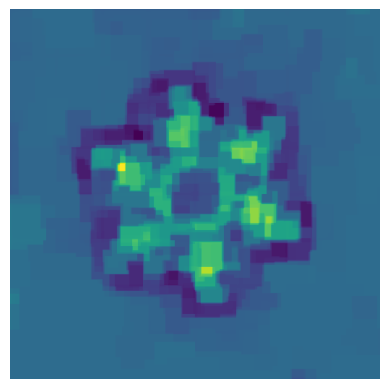

In [5]:
plt.imshow(image)
plt.axis("off")

In [6]:

frc = np.load(path + "_frc.npy")

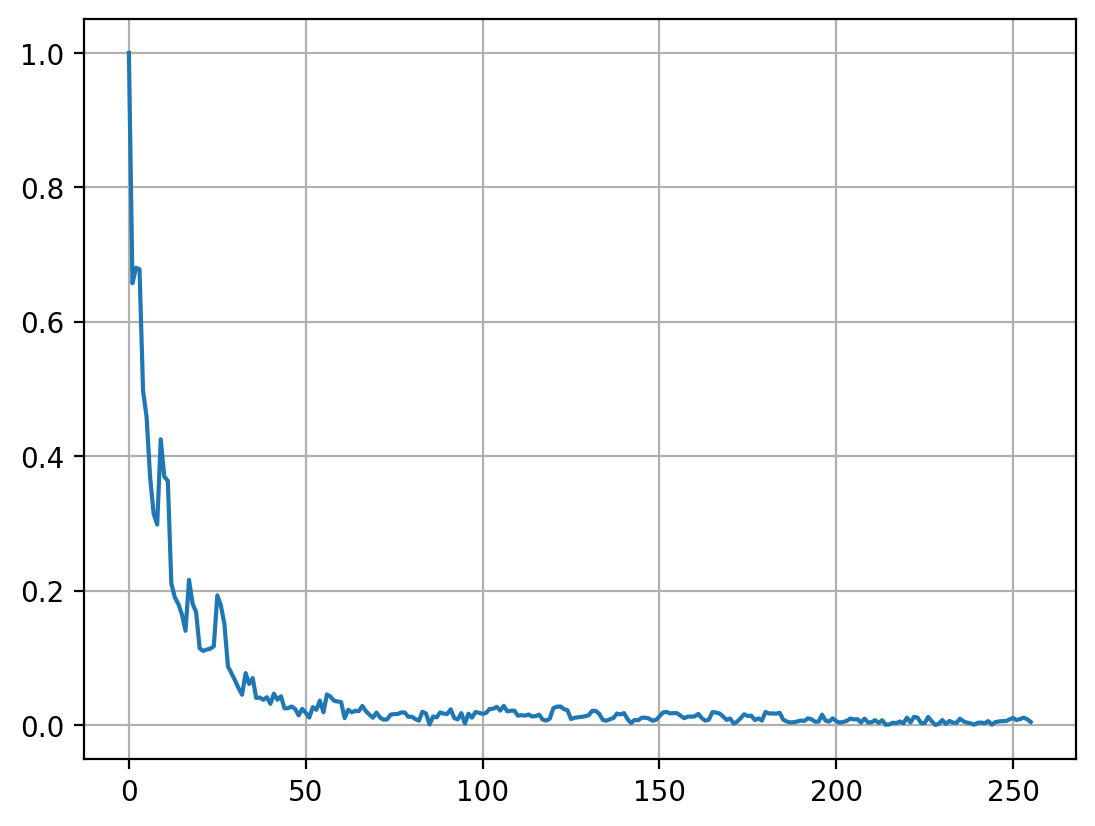

In [7]:
plt.figure(dpi = 200)
plt.plot(frc)
plt.grid()

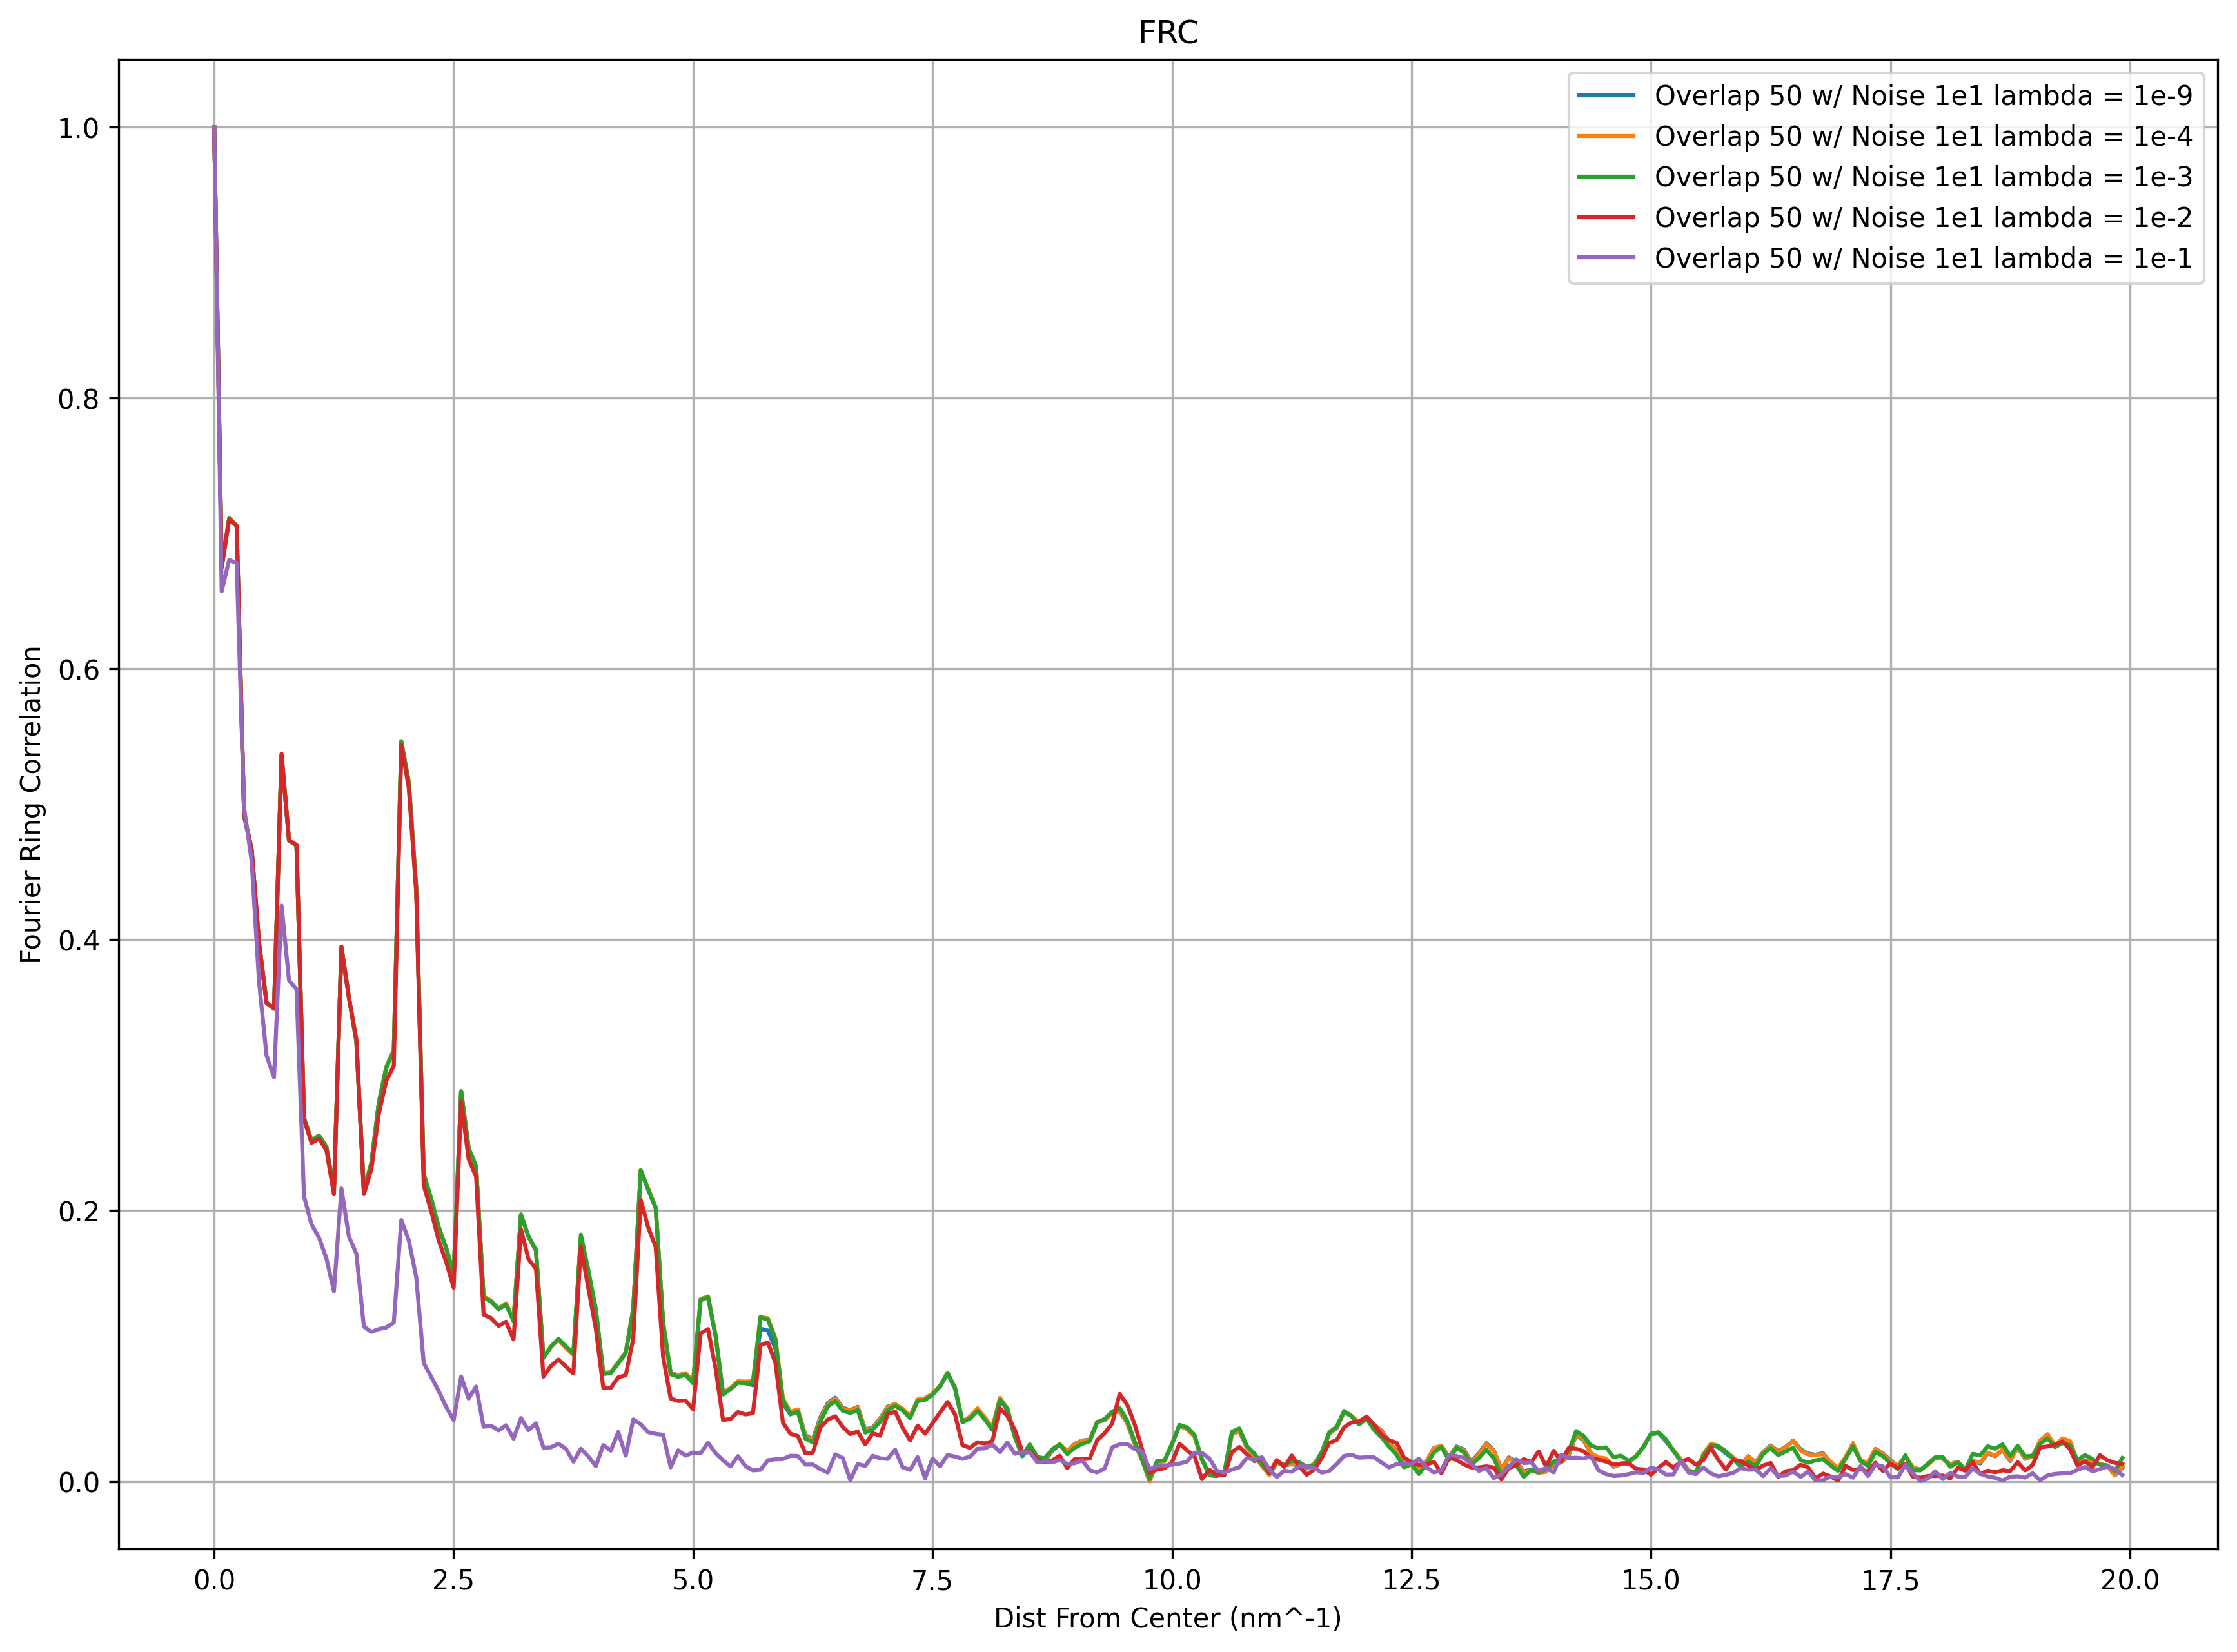

In [9]:
frc1 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise10.0_frc.npy")
frc2 = np.load("data/cpwc_overlap50_mrgd_lambda0.0001_noise_typepoisson_noise10.0_frc.npy")
frc3 = np.load("data/cpwc_overlap50_mrgd_lambda0.001_noise_typepoisson_noise10.0_frc.npy")
frc4 = np.load("data/cpwc_overlap50_mrgd_lambda0.01_noise_typepoisson_noise10.0_frc.npy")
frc5 = np.load("data/cpwc_overlap50_mrgd_lambda0.1_noise_typepoisson_noise10.0_frc.npy")
fourier_k_range = np.fft.fftfreq(512) / 0.25
fourier_k_range = fourier_k_range[0:256] * 10 
plt.figure(dpi = 300,figsize=(14,10))
plt.plot(fourier_k_range,frc1)
plt.plot(fourier_k_range,frc2)
plt.plot(fourier_k_range,frc3)
plt.plot(fourier_k_range,frc4)
plt.plot(fourier_k_range,frc5)
plt.grid()
plt.legend(["Overlap 50 w/ Noise 1e1 lambda = 1e-9",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-4",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-3",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-2",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-1"])
plt.title("FRC")
plt.xlabel("Dist From Center (nm^-1)")
plt.ylabel("Fourier Ring Correlation")
plt.show()


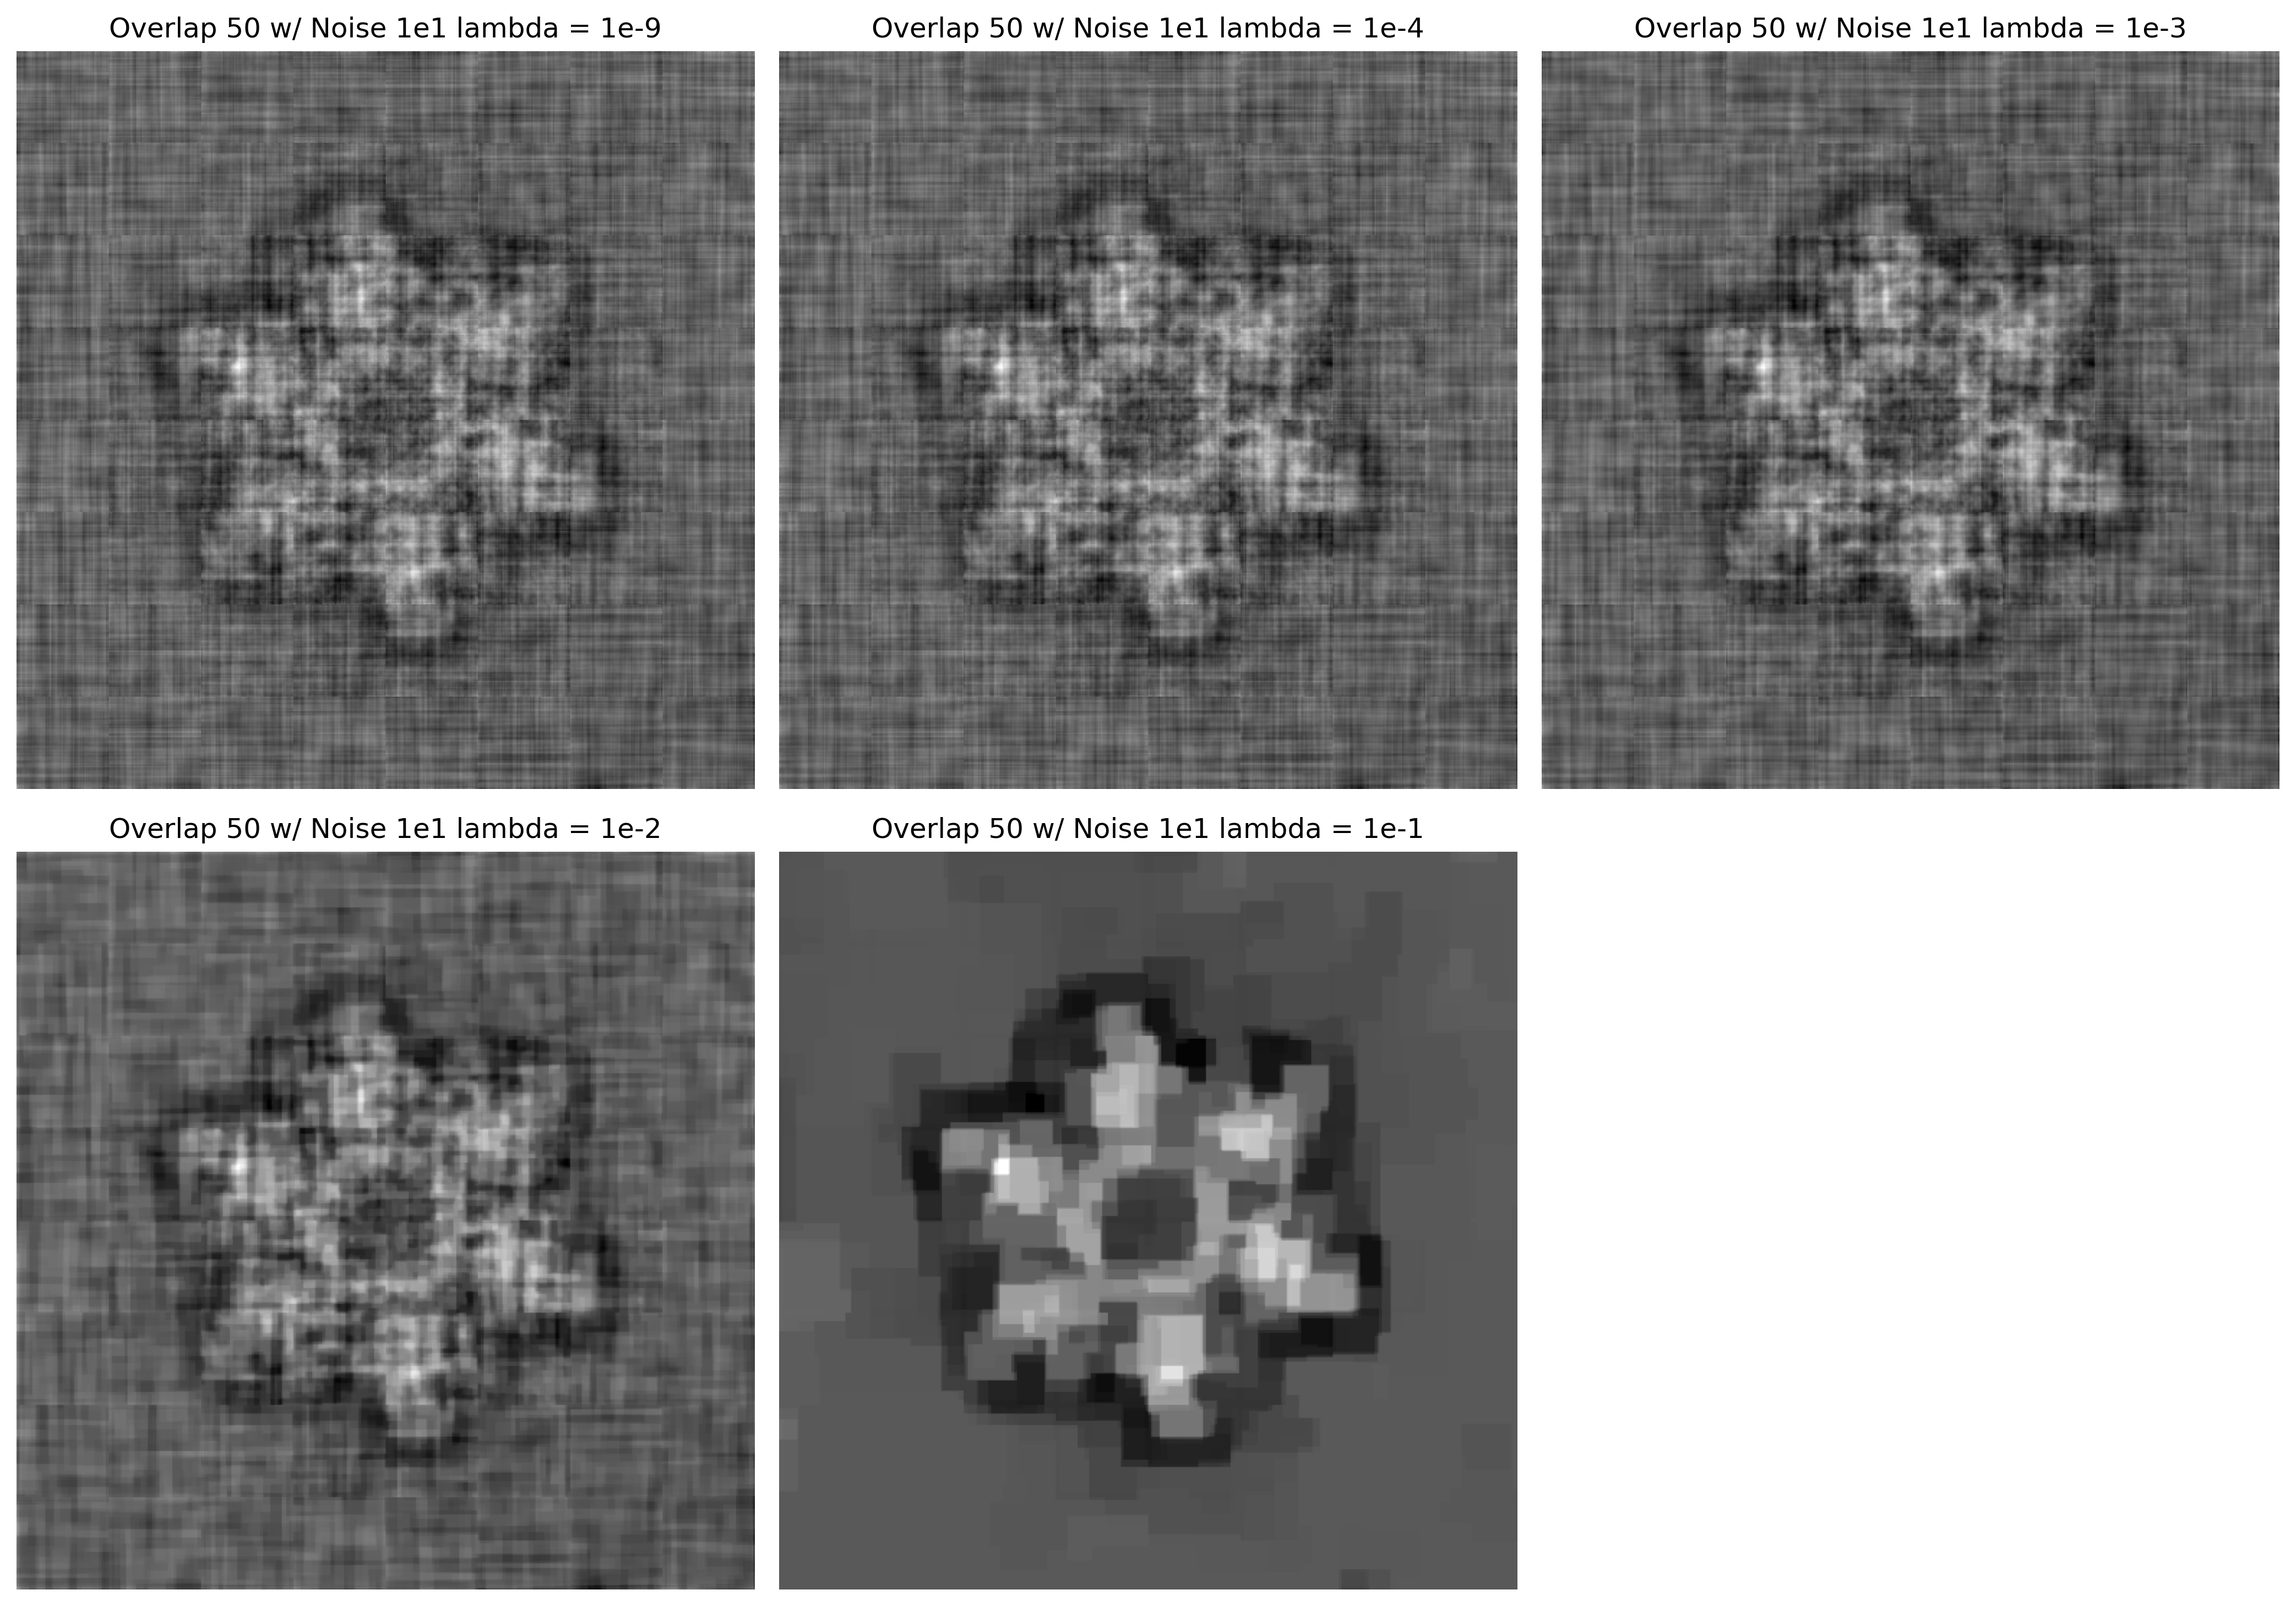

In [11]:
img1 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise10.0_image.npy")
img2 = np.load("data/cpwc_overlap50_mrgd_lambda0.0001_noise_typepoisson_noise10.0_image.npy")
img3 = np.load("data/cpwc_overlap50_mrgd_lambda0.001_noise_typepoisson_noise10.0_image.npy")
img4 = np.load("data/cpwc_overlap50_mrgd_lambda0.01_noise_typepoisson_noise10.0_image.npy")
img5 = np.load("data/cpwc_overlap50_mrgd_lambda0.1_noise_typepoisson_noise10.0_image.npy")
plt.figure(dpi = 300,figsize=(14,10))
plt.subplot(2,3,1)
plt.imshow(img1, cmap = "gray")
plt.axis("off")
plt.title("Overlap 50 w/ Noise 1e1 lambda = 1e-9")
plt.subplot(2,3,2)
plt.imshow(img2, cmap = "gray")
plt.axis("off")
plt.title("Overlap 50 w/ Noise 1e1 lambda = 1e-4")
plt.subplot(2,3,3)
plt.imshow(img3, cmap = "gray")
plt.axis("off")
plt.title("Overlap 50 w/ Noise 1e1 lambda = 1e-3")
plt.subplot(2,3,4)
plt.imshow(img4, cmap = "gray")
plt.axis("off")
plt.title("Overlap 50 w/ Noise 1e1 lambda = 1e-2")
plt.subplot(2,3,5)
plt.imshow(img5, cmap = "gray")
plt.axis("off")
plt.title("Overlap 50 w/ Noise 1e1 lambda = 1e-1")
plt.tight_layout()
plt.show()


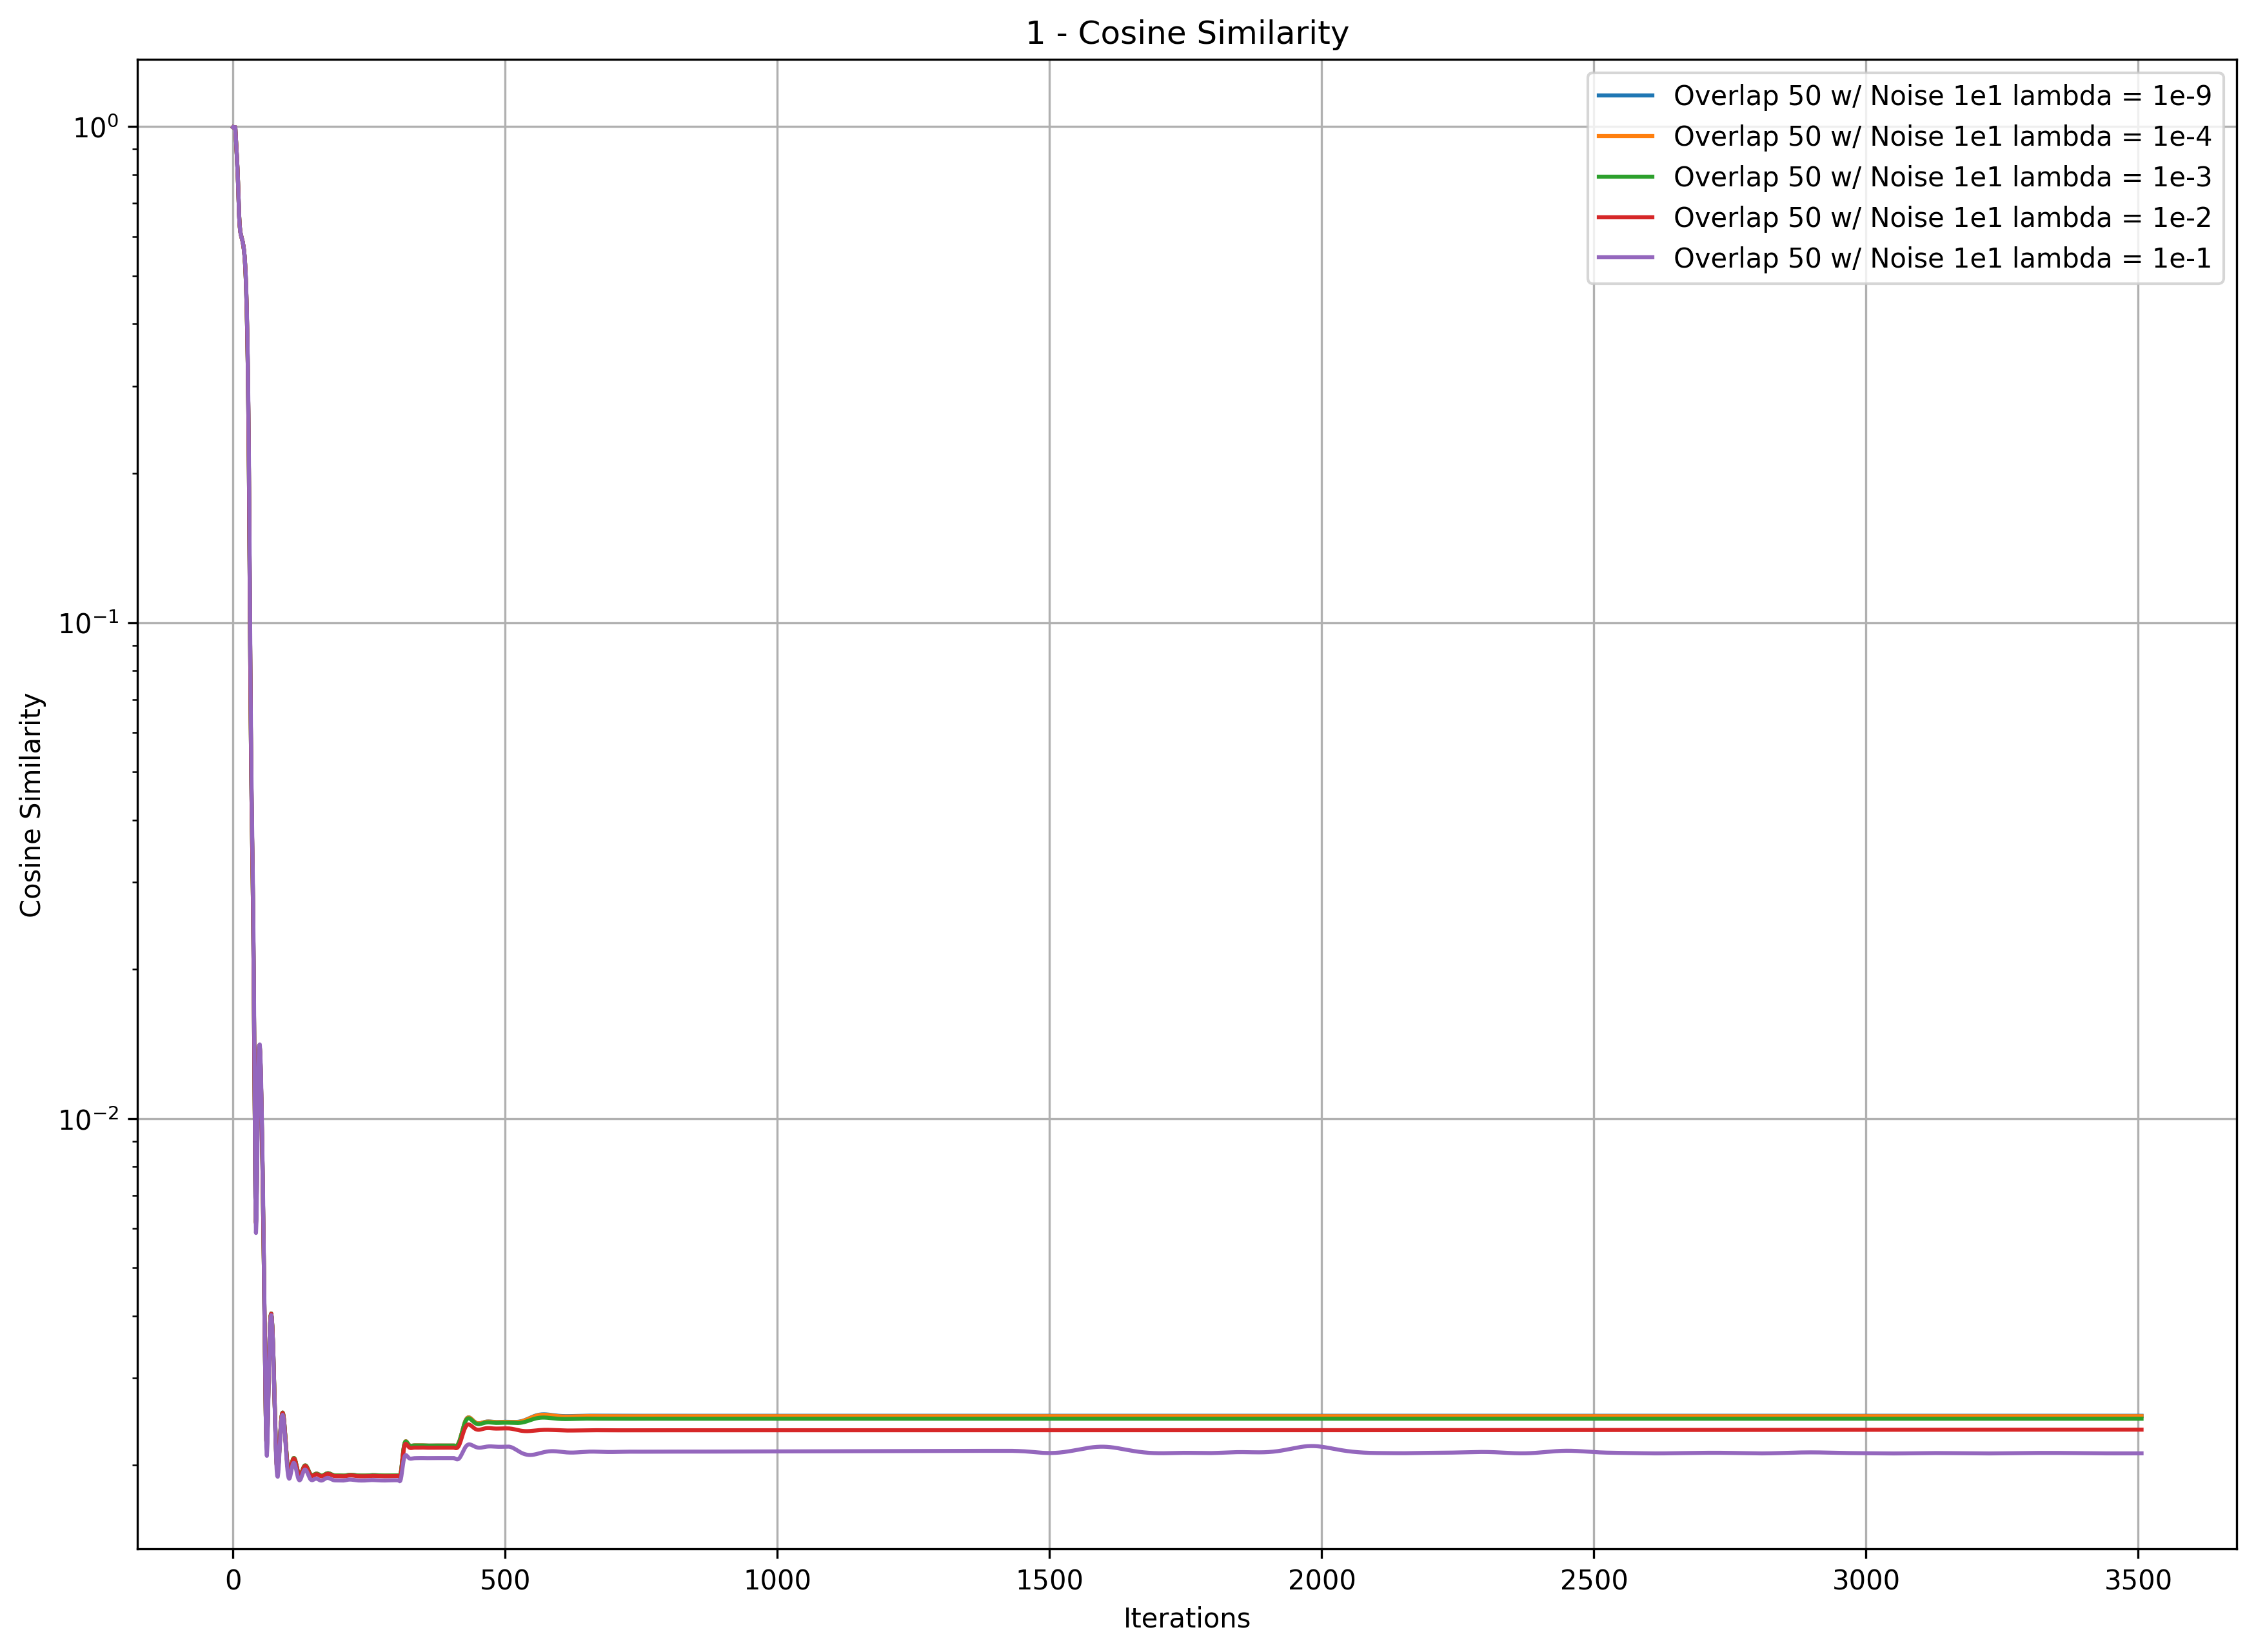

In [12]:
csim1 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise10.0_csim.npy")
csim2 = np.load("data/cpwc_overlap50_mrgd_lambda0.0001_noise_typepoisson_noise10.0_csim.npy")
csim3 = np.load("data/cpwc_overlap50_mrgd_lambda0.001_noise_typepoisson_noise10.0_csim.npy")
csim4 = np.load("data/cpwc_overlap50_mrgd_lambda0.01_noise_typepoisson_noise10.0_csim.npy")
csim5 = np.load("data/cpwc_overlap50_mrgd_lambda0.1_noise_typepoisson_noise10.0_csim.npy")

plt.figure(dpi = 300,figsize=(14,10))
plt.semilogy(1-csim1)
plt.semilogy(1-csim2)
plt.semilogy(1-csim3)
plt.semilogy(1-csim4)
plt.semilogy(1-csim5)
plt.grid()
plt.legend(["Overlap 50 w/ Noise 1e1 lambda = 1e-9",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-4",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-3",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-2",
            "Overlap 50 w/ Noise 1e1 lambda = 1e-1"])
plt.title("1 - Cosine Similarity")
plt.xlabel("Iterations")
plt.ylabel("Cosine Similarity")
plt.show()
